In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, curve_fit
%matplotlib notebook

### Description of the code

Numerical solution to evolve an adiatic shock of index 5/3 using donor the cell advection technique.

You will also find Q1's coding part, but the figures themselves have been included in the CM submission.


#### Name: Maude Larivière (260925122)
Collab: Amalia Karalis, Ana Hoban, Jasmine Zhang (She helped me after she submitted since I had an extension and I started this question after the original deadline). 

Date: March 25th, 2022

## Q2

Some context first:

Need to solve the 3 conservation equations. For mass, there are no source term: $\rho_1 u_1 = \rho_2 u_2$. We can use the advection code with no source term.

For momentum, we will have a source term, equivalent to the pressure gradient: $\partial_t (\rho u_i) + \partial_j (\rho u_i u_j) = -\partial_i P$, so using the fact that there is no mass accumulation across shock, we get $\Delta (\rho u) = dt/dx \Delta P$, where $dt/dx$ comes from the numerical solving.

For energy, we also have a pressure gradient: $\partial_t (\rho E) + \nabla ((\rho E + P)u) = 0$ for an adiabatic shock. This leads to $\Delta (\rho E) = -dt/dx \Delta (Pu)$.

In each case, we need to find a way to express $P$ has a function of $\rho, \rho U and \rho E$.

Now, the total energy is $\rho E_{tot} = KE + \epsilon = 1/2 \rho u^2 + \rho \epsilon$. From a previous assignement, we found that $\epsilon = 1/(\gamma - 1) P/\rho)$, so we can use that in the total energy and solve for $P$. This yields $P = (\rho E_{tot} - 0.5 \rho u^2) (\gamma - 1)$.

<IPython.core.display.Javascript object>


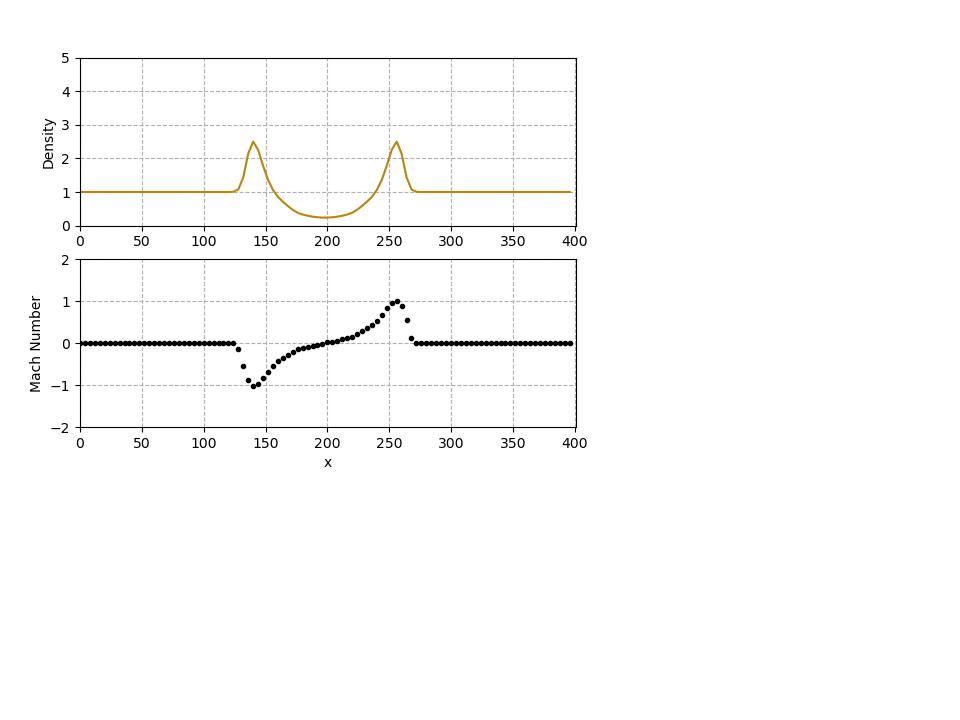

In [ ]:
# Define variables
nGrid = 100
nSteps = 1500
dt = 0.01
dx = 4.
gamma = 5/3

x = np.arange(nGrid) * dx # distance grid
rho = np.ones(nGrid) # mass grid
rhoU = np.zeros(nGrid) # momentum grid
rhoE = np.ones(nGrid) # energy grid
uAdv = np.zeros(nGrid+1) # advective velocity

# Using adiabatic concept, we can find the pressure, the sound speed and Mach number
P = (rhoE - 0.5*rhoU**2/rho ) * (gamma-1) # setting k to 1
cs2 = gamma * P / rho
mach2 = (rhoU/rho)**2/cs2 # (rho * u / rho)^2 / cs2 = u^2/cs^2

# Function to compute the advection -- Prof. Lee's function
def advection(f, u, dt, dx):
     # Calculating flux terms
    J = np.zeros(len(f)+1)
    # Find actual fluxes
    # If positive adv velocity, the flux comes from the right so all terms but last have an outgoing flux
    # If negative asd velocity, the flux comes from the left so all terms but first have an outgoing flux
    # To implement reflective BC --> need [0] and [-1] elements = 0, so we use [1:-1] indices
    J[1:-1] = np.where(u[1:-1] > 0, f[:-1] * u[1:-1], f[1:] * u[1:-1])
    # Updating our function with the advection value
    f = f - (dt / dx) * (J[1:] - J[:-1]) 
    
    return f

# Apply the Gaussian perturbation
Amp, sigma = 100, nGrid/10 # Get the Gaussian params, big perturbation
rhoE = rhoE + Amp * np.exp(-(x - x.max()/2) ** 2 / sigma ** 2) # Pert for rho * energy

# Plotting
plt.ion()
fig, ax = plt.subplots(2,1)

x1, = ax[0].plot(x, rho, color='darkgoldenrod')
x2, = ax[1].plot(x, np.sqrt(mach2), '.', color='black')

ax[0].set_xlim([0, dx*nGrid+1])
ax[0].set_ylim([0., 5])
ax[1].set_xlim([0, dx*nGrid+1])
ax[1].set_ylim([-2, 2])

ax[1].set_xlabel('x')
ax[0].set_ylabel('Density')
ax[1].set_ylabel('Mach Number')

ax[0].grid(ls='--')
ax[1].grid(ls='--')

fig.canvas.draw()

for i in range(nSteps):
    #print(i)
    # Get adv velocity at interface
    # Half contribution from previous and half for posterior
    uAdv[1:-1] = 0.5 * ((rhoU[:-1] / rho[:-1]) + (rhoU[1:] / rho[1:]))
    
    # Update density and momentum
    rhoU = advection(rhoU, uAdv, dt, dx)
    rho = advection(rho, uAdv, dt, dx)
    
    # Introduce source term for momentum (pressure gradient)
    P = (rhoE - 0.5*rhoU**2/rho) * (gamma-1)
    cs2 = gamma * P / rho
    rhoU[1:-1] = rhoU[1:-1] - 0.5 * (dt / dx) * (P[2:]-P[:-2])
    
    # Apply proper BC
    rhoU[0] = rhoU[0] - 0.5 * (dt/dx) * (P[1] - P[0])
    rhoU[-1] = rhoU[-1] - 0.5 * (dt/dx) * (P[-1] - P[-2])
    
    # Recompute adv velocity
    uAdv[1:-1] = 0.5 * ((rhoU[:-1] / rho[:-1]) + (rhoU[1:] / rho[1:]))
    
    # Advect energy
    rhoE = advection(rhoE, uAdv, dt, dx)
    
    # Introduce source term for energy (pressure gradient => d(rhoE) = d(Pu))
    P = (rhoE - 0.5*rhoU**2/rho) * (gamma-1)
    P_u = P * rhoU / rho
    rhoE[1:-1] = rhoE[1:-1] - 0.5 * (dt/dx) * (P_u[2:] - P_u[:-2])
    
    # Apply proper BC
    rhoE[0] = rhoE[0] - 0.5 * (dt/dx) * (P_u[1] - P_u[0])
    rhoE[-1] = rhoE[-1] - 0.5 * (dt/dx) * (P_u[-1] - P_u[-2])
    
    # Recalculate pressure and cs2
    P = (rhoE - 0.5*rhoU**2/rho ) * (gamma-1)
    cs2 = gamma * P / rho
    mach = rhoU / rho / np.sqrt(cs2)
    
    # Update plot
    x1.set_ydata(rho)
    x2.set_ydata(mach)
    fig.canvas.draw()
    plt.pause(0.001)
    

1) If we consider that pre-shock, we have a density of 1, then we would expect a density of 4 for adiabatic index 5/3, because In the strong shock limit, we derived in class that $\rho_1 / \rho_2 = 1/4$, so we'd expect our $\rho_2$ to go over to 4. From this (See the png called PeakRho2) snapshot, we see that we indeed have something at about 3, so it is not technically what we would expect, but it definitely close.

2) I am having trouble figuring this one out. I can't seem to be finding params that change the width without disrupting the running of the code itself. I've tried changing dx, dt, the size of the perturbation and the initial density. All the plots can be found under the name Width_(something).png. For some reason, under some of these changes, we actually get the peak of 4 we would expect. I am a bit confused because I thought the shock width depended on velocity and viscosity, but we also had it in terms of the inverse Mach number and lambda mfp, so something to do with density and velocity. Looking at the numerical notes (the 1st doc), we see that numerical viscosity can be estimated as $dx^2/(2dt)$. I tried doing some plots decreasing dt and increasing dx at the same time to increase viscosity and it seems like there is a change, but it's hard to tell since the grid changes.

## Q1.2

In [ ]:
%matplotlib inline

flyingSpeed = np.linspace(0.1, 1000, 10000) # m/s
masses = np.array([0.01, 0.1, 1., 10., 100.]) # kg

def costTransport(u, m):
    return 0.025 * (m/0.035)**(1/3) * (10/u)**2 + 0.023 * (m/0.035)**(-1/3) * \
                (u/10)**2 + 1.073 * (m/0.035)**(-1/4) * (10/u)

plt.figure(figsize=(7,7))
plt.xscale('log')
plt.yscale('log')

cost = []

for i in masses:
    cost_i = costTransport(flyingSpeed,i)
    cost.append(cost_i)
    plt.plot(flyingSpeed,cost_i,label=str(i)+' kg')

plt.xlabel('Flying Speed (m/s)',fontsize=15)
plt.ylabel('Cost of Transport (unitless)',fontsize=15)
plt.title('Cost of Transport in terms of Flying Speed for 5 different masses', fontsize=15)
plt.grid(ls='--')
plt.legend(loc=0,fontsize=15)
plt.savefig('Lariviere_Fluids_Pset4_Q1b.pdf',bbox_inches='tight')
plt.show()

## Q1.3

In [ ]:
# An array to store the minimal velocity
minVel = np.zeros(len(masses))
minCost = np.zeros(len(masses))

# Using scipy.optimize.minimize to find minimum of each function
for i in range(len(minVel)):
    minimized = minimize(costTransport,[10],args=(masses[i]))
    minVel[i] = minimized['x'] # Actual value of velocity with ['x']
    minCost[i] = minimized['fun'] # Minimum value

In [ ]:
# Do the power law fitting
def powerLaw(x, k, a):
    return k*x**a

# Curve fit using numerical tools
popt,pcov = curve_fit(powerLaw,masses,minCost)
massArray = np.linspace(0.01,100,10000)
print(popt)

# Plotting
plt.figure(figsize=(7,7))
plt.plot(masses,minCost,'o',color='darkgoldenrod')
plt.plot(massArray,powerLaw(massArray,popt[0],popt[1]),'k',ls='--',\
         label=r'Power Law fit, $E_{min}=%1.2f m^{%1.2f}$' % (popt[0],popt[1]))
plt.grid(ls='--')
plt.xlabel('Mass (kg)',fontsize=15)
plt.ylabel('Minimum Cost of Transport (unitless)',fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.legend(loc=0,fontsize=15)
plt.title('Power Law Fit for Min Cost of Transport',fontsize=15)
plt.savefig('Lariviere_Fluids_Pset4_Q1c.pdf',bbox_inches='tight')
plt.show()